# Akbank Bootcamp Projesi

## Airplane – Car – Ship Görsel Sınıflandırma Projesi

Bu projenin amacı, görüntülerden **uçak, araba ve gemi** sınıflarını ayırt edebilen 
bir **CNN tabanlı derin öğrenme modeli** geliştirmektir.  
Proje kapsamında veri önişleme, model eğitimi, değerlendirme ve hiperparametre optimizasyonu adımları uygulanacaktır.


## Öncelikle veri dağılımını görselleştirip bakalım

Sınıflar: ['ship', 'cars', 'airplanes']
Train dağılımı: {'ship': 850, 'cars': 850, 'airplanes': 850}
Test dağılımı: {'ship': 200, 'cars': 193, 'airplanes': 189}


/tmp/ipykernel_1630571/2674131454.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues_d")
/tmp/ipykernel_1630571/2674131454.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="Greens_d")
/tmp/ipykernel_1630571/2674131454.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/comp5/ARTEK/umut/AkbankBootcamp/akbank_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


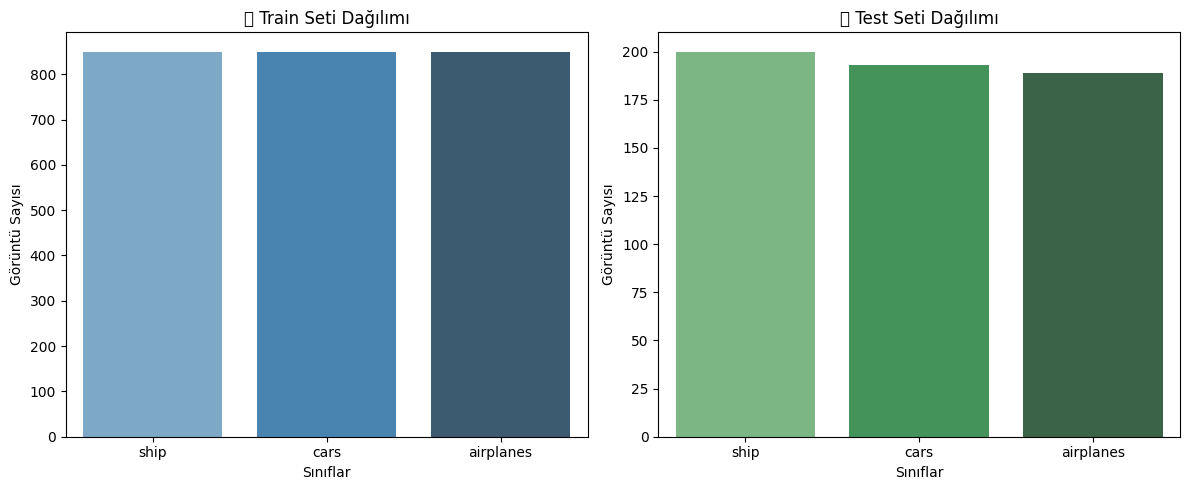

/tmp/ipykernel_1630571/2674131454.py:56: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/comp5/ARTEK/umut/AkbankBootcamp/akbank_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


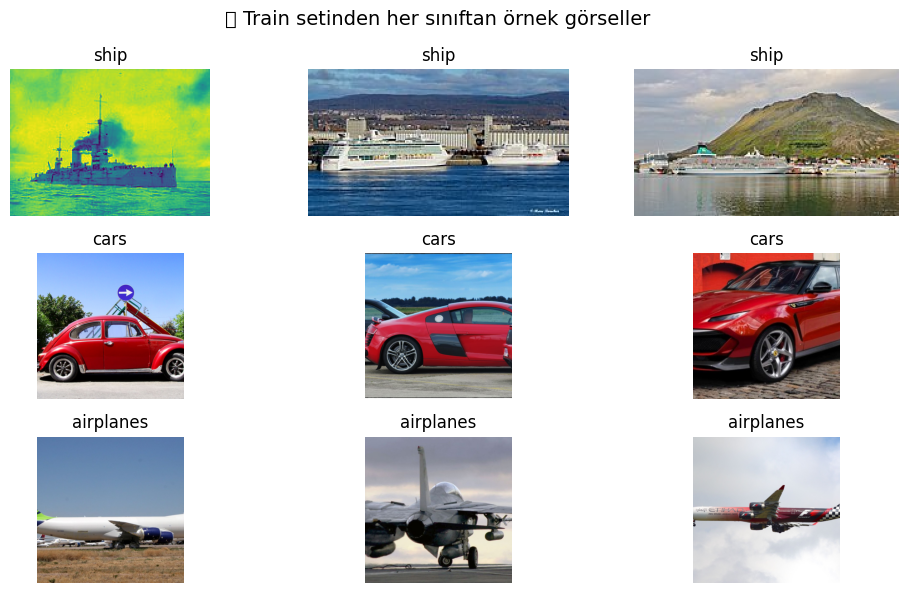

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
# 📂 Veri seti yolları
train_dir = "/home/comp5/ARTEK/umut/AkbankBootcamp/dataset_akbank/train"
test_dir = "/home/comp5/ARTEK/umut/AkbankBootcamp/dataset_akbank/test"

# Sınıfları al
classes = os.listdir(train_dir)
print("Sınıflar:", classes)

# Train ve Test dağılımları
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

print("Train dağılımı:", train_counts)
print("Test dağılımı:", test_counts)

# 🔹 Train dağılımı grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues_d")
plt.title("📊 Train Seti Dağılımı")
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Sınıflar")

# 🔹 Test dağılımı grafiği
plt.subplot(1, 2, 2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="Greens_d")
plt.title("📊 Test Seti Dağılımı")
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Sınıflar")

plt.tight_layout()
plt.show()

# 🔹 Train setinden örnek görseller
plt.figure(figsize=(10, 6))
for idx, cls in enumerate(classes):
    class_path = os.path.join(train_dir, cls)
    images = os.listdir(class_path)
    sample_images = random.sample(images, 3)

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(len(classes), 3, idx*3 + i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)

plt.suptitle("📸 Train setinden her sınıftan örnek görseller", fontsize=14)
plt.tight_layout()
plt.show()


### Yukardaki dağılıma baktığımız zaman dengeli bir sınıfımız olduğunu görüyoruz. Şimdi ön işleme kısmına geçelim

## Veri Önişleme

### Bu aşamada veri seti train/val/test olarak organize edilmiştir.  
Val seti, train’den %15 oranında ayrılmıştır.  

Görseller üzerinde şu önişlemeler uygulanacaktır:
- Oranı koruyarak **letterbox + resize (224x224)**
- Train için hafif veri artırma (**random horizontal flip, küçük rotation**)
- Val/Test için sadece deterministik ölçekleme
- Normalize (ImageNet mean/std)

Amaç: Nesnelerin şekil ve arka plan özelliklerini koruyarak modelin öğrenmesini sağlamaktır.

In [5]:
# --- Gereken kütüphaneler ---
import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# --- Letterbox fonksiyonu ---
def letterbox_pil(img: Image.Image, size=224, pad_color=(0,0,0)):
    w, h = img.size
    scale = min(size / w, size / h)
    nw, nh = int(w * scale), int(h * scale)
    im = img.resize((nw, nh), Image.BICUBIC)
    canvas = Image.new("RGB", (size, size), pad_color)
    canvas.paste(im, ((size - nw)//2, (size - nh)//2))
    return canvas

### Transform Tanımları
- **Train Transform:** Letterbox + Augmentation + Normalize  
- **Val/Test Transform:** Letterbox + Normalize


In [6]:
IMG_SIZE = 224
BS = 32
NUM_WORKERS = 2

# Normalizasyon için ImageNet ortalama / std
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Val/Test: deterministik
eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: letterbox_pil(im, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Train: deterministik + augmentation
train_tf = transforms.Compose([
    transforms.Lambda(lambda im: letterbox_pil(im, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


### Dataset ve DataLoader
Train/Val/Test klasörleri ImageFolder formatında okunur.  
DataLoader ile batch halinde modele aktarılır.


In [7]:
ROOT = "/home/comp5/ARTEK/umut/AkbankBootcamp/dataset_akbank"  # senin dataset kökün

train_ds = datasets.ImageFolder(os.path.join(ROOT, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(ROOT, "val"),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(ROOT, "test"),  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)

print("Sınıflar:", class_names)


Sınıflar: ['airplanes', 'cars', 'ship']


### Veri Seti Özet
Her sınıfın train/val/test dağılımı aşağıda incelenebilir.


/tmp/ipykernel_1630571/3689127838.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axs[0], palette="Blues")
/tmp/ipykernel_1630571/3689127838.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=axs[1], palette="Oranges")
/tmp/ipykernel_1630571/3689127838.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=axs[2], palette="Greens")


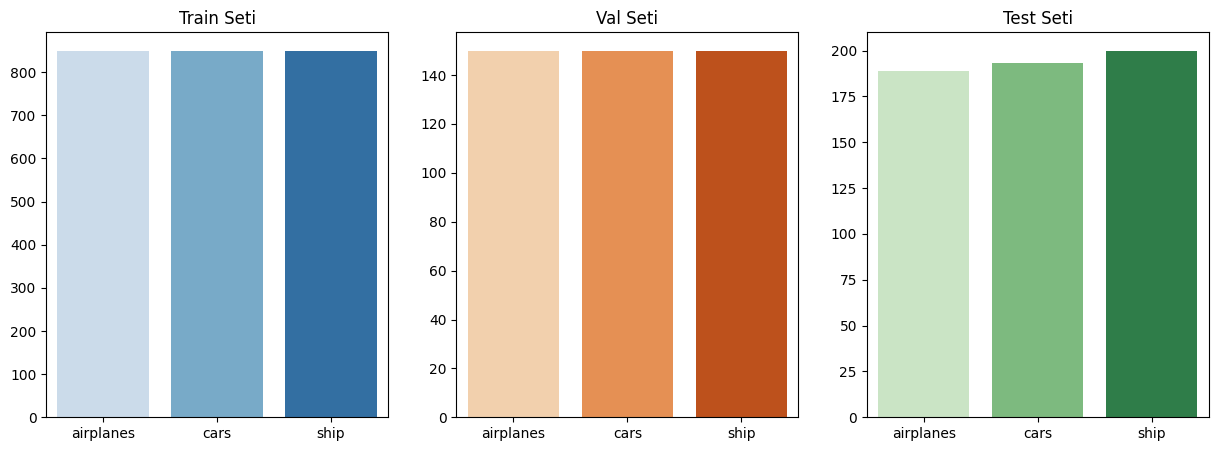

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def count_images(path):
    counts = {}
    for cls in class_names:
        cls_path = os.path.join(path, cls)
        counts[cls] = len([f for f in os.listdir(cls_path) if f.lower().endswith(('jpg','jpeg','png'))])
    return counts

train_counts = count_images(os.path.join(ROOT, "train"))
val_counts   = count_images(os.path.join(ROOT, "val"))
test_counts  = count_images(os.path.join(ROOT, "test"))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axs[0], palette="Blues")
axs[0].set_title("Train Seti")
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=axs[1], palette="Oranges")
axs[1].set_title("Val Seti")
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=axs[2], palette="Greens")
axs[2].set_title("Test Seti")
plt.show()


## Modelin Eğitilmesi

Bu bölümde **CNN tabanlı bir model** eğitilecektir.  
Başlangıç için **Transfer Learning (ResNet18)** kullanılacak, son katman proje sınıflarına göre yeniden düzenlenecektir.  

Eğitim sırasında:
- Loss fonksiyonu: CrossEntropyLoss  
- Optimizer: Adam  
- Öğrenme hızı: 1e-3  
- Erken durdurma (Early Stopping) uygulanacaktır. 

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# ResNet18 modelini yükle
model = resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)  # son katmanı güncelle
model = model.to(device)

# Loss ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# LR Scheduler (val loss iyileşmezse öğrenme hızını düşür)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


Kullanılan cihaz: cuda


### Eğitim Fonksiyonları
Train ve Validation döngüsü ayrı fonksiyonlarla tanımlanır.


In [10]:
from tqdm import tqdm

def run_epoch(loader, model, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Train" if train else "Val", leave=False):
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total


### Eğitim Döngüsü
Epoch bazında train/val loss ve accuracy değerleri takip edilecektir.  
En iyi model `best_model.pth` dosyasına kaydedilecektir.


In [13]:
EPOCHS = 15
best_val_loss = float("inf")
patience, wait = 3, 0
best_path = "best_model.pth"

train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, model, train=True)
    val_loss, val_acc = run_epoch(val_loader, model, train=False)
    scheduler.step(val_loss)

    train_hist.append((tr_loss, tr_acc))
    val_hist.append((val_loss, val_acc))

    print(f"[{epoch:02d}] Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.3f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")

    if val_loss < best_val_loss:
        best_val_loss, wait = val_loss, 0
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path)
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping tetiklendi.")
            break


[01] Train Loss: 0.0313, Acc: 0.992 | Val Loss: 0.0638, Acc: 0.980


[02] Train Loss: 0.0535, Acc: 0.980 | Val Loss: 0.0528, Acc: 0.982


[03] Train Loss: 0.0618, Acc: 0.980 | Val Loss: 0.1733, Acc: 0.929


[04] Train Loss: 0.0253, Acc: 0.993 | Val Loss: 0.0292, Acc: 0.991


[05] Train Loss: 0.0096, Acc: 0.998 | Val Loss: 0.0349, Acc: 0.993


[06] Train Loss: 0.0112, Acc: 0.995 | Val Loss: 0.0365, Acc: 0.982


[07] Train Loss: 0.0094, Acc: 0.996 | Val Loss: 0.0375, Acc: 0.991
Early stopping tetiklendi.


### Eğitim Grafikleri
Epoch bazında Accuracy ve Loss grafikleri.


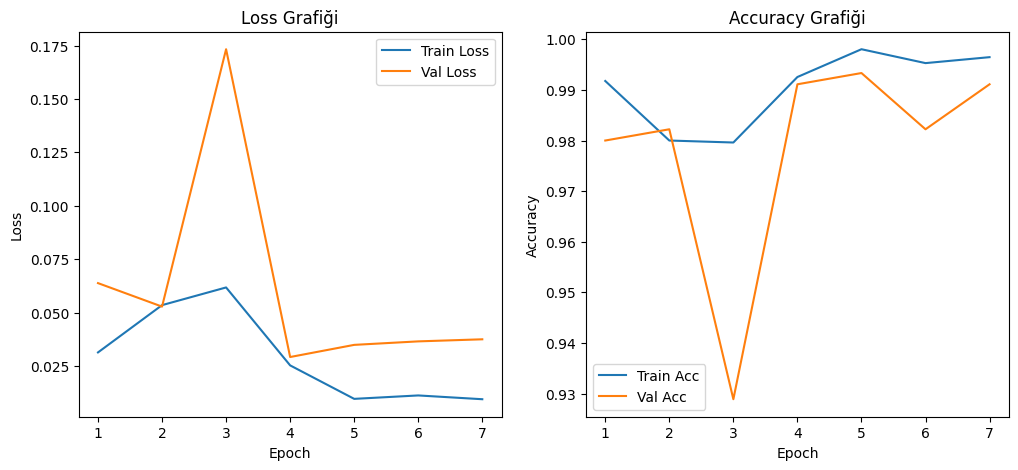

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_hist)+1)
tr_loss = [x[0] for x in train_hist]
tr_acc  = [x[1] for x in train_hist]
val_loss = [x[0] for x in val_hist]
val_acc  = [x[1] for x in val_hist]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss Grafiği")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, tr_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy Grafiği")
plt.legend()

plt.show()


## Modelin Değerlendirilmesi
Bu bölümde eğitilen model, **test seti** üzerinde değerlendirilecektir.

- **Metrikler:** Confusion Matrix, Classification Report (Precision, Recall, F1)
- **Örnekleme:** Yanlış sınıflandırılan görsellerin görselleştirilmesi
- **Açıklanabilirlik:** Grad-CAM ile modelin dikkat ettiği bölgeler

In [15]:
# ✅ En iyi modeli yükle ve test setinde tahmin yap
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_path = "best_model.pth"  # eğitim bölümünde kaydetmiştik
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred = logits.argmax(1).cpu().numpy()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("Test örnek sayısı:", len(y_true))
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Test örnek sayısı: 582
              precision    recall  f1-score   support

   airplanes     1.0000    0.9841    0.9920       189
        cars     0.9847    1.0000    0.9923       193
        ship     1.0000    1.0000    1.0000       200

    accuracy                         0.9948       582
   macro avg     0.9949    0.9947    0.9948       582
weighted avg     0.9949    0.9948    0.9948       582



### Confusion Matrix
Hem **ham sayılar** hem de **normalize (% olarak)** gösterilecektir.


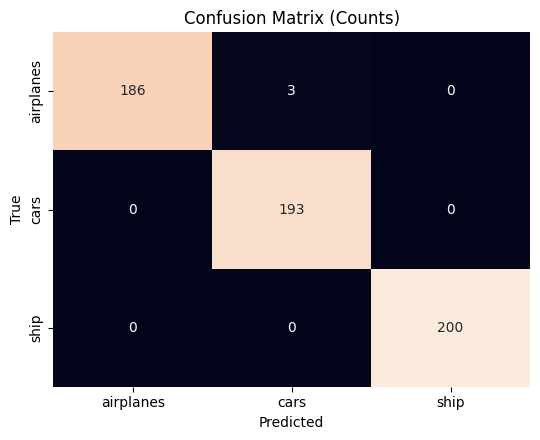

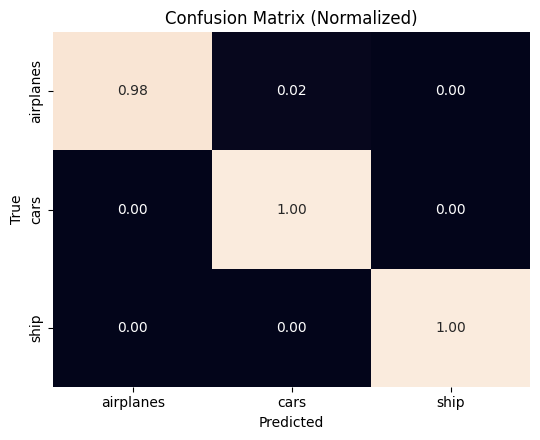

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, labels, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)), normalize=("true" if normalize else None))
    plt.figure(figsize=(5.5,4.5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", 
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_cm(y_true, y_pred, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_cm(y_true, y_pred, class_names, normalize=True,  title="Confusion Matrix (Normalized)")


### Yanlış Sınıflandırılan Örnekler
En yüksek eminlikle (softmax skoru) **yanlış** tahmin edilen görsellerden bir seçki.


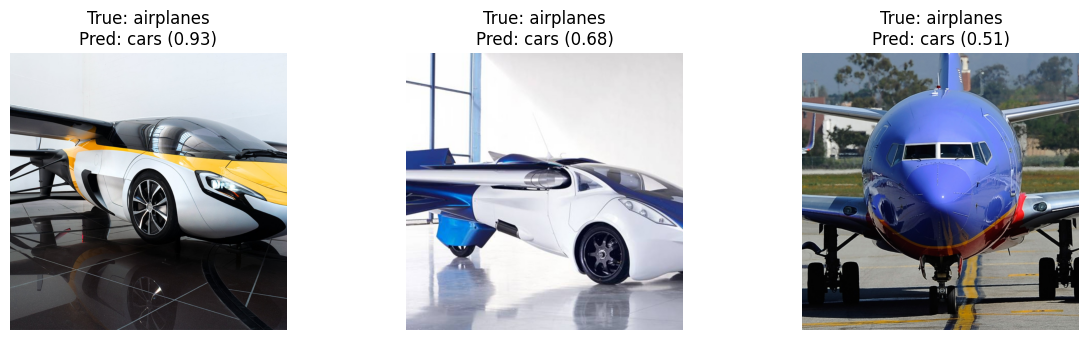

In [17]:
import os, math
from PIL import Image

# test_ds: ImageFolder; samples -> (path, class_idx)
test_paths = [s[0] for s in test_ds.samples]

wrong_idx = np.where(y_true != y_pred)[0]
# En emin olunan yanlışlardan 12 tanesini seç (skor farkına göre)
if len(wrong_idx) > 0:
    conf_scores = y_prob[wrong_idx, y_pred[wrong_idx]]  # yanlış tahmin edilen sınıfın skoru
    order = np.argsort(-conf_scores)  # azalan
    show_idx = wrong_idx[order][:12]
else:
    show_idx = []

cols = 4
rows = math.ceil(len(show_idx)/cols) if len(show_idx)>0 else 1
plt.figure(figsize=(4*cols, 3.5*rows))

for i, idx in enumerate(show_idx):
    img = Image.open(test_paths[idx]).convert("RGB")
    plt.subplot(rows, cols, i+1)
    plt.imshow(img); plt.axis("off")
    t, p = class_names[y_true[idx]], class_names[y_pred[idx]]
    s = y_prob[idx, y_pred[idx]]
    plt.title(f"True: {t}\nPred: {p} ({s:.2f})")

if len(show_idx) == 0:
    plt.text(0.5, 0.5, "Hatalı örnek bulunamadı 🎉", ha="center", va="center", fontsize=14)
    plt.axis("off")

plt.tight_layout(); plt.show()


### Grad-CAM (Açıklanabilirlik)

Aşağıda **ResNet18** için son konvolüsyon katmanından Grad-CAM ısı haritası üretimi yapılır.
- Test setinden birkaç örnek alınıp **orijinal + CAM + overlay** görselleri çizilir.


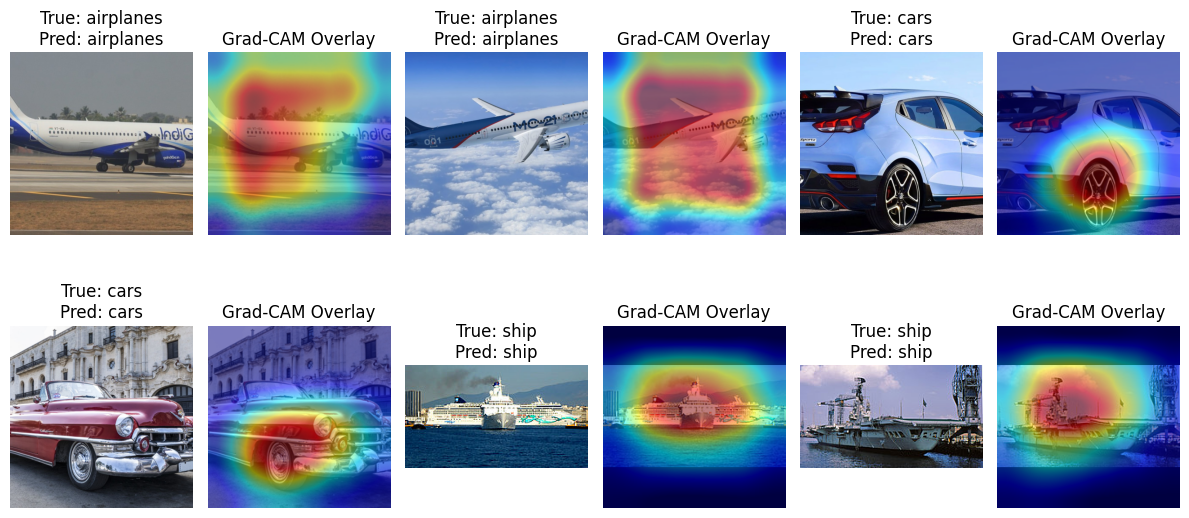

In [20]:
# ---- (1) Eski hook'lar varsa kapat ----
try:
    h1.remove()
except Exception:
    pass
try:
    h2.remove()
except Exception:
    pass

# ---- (2) Sadece FORWARD hook ile Grad-CAM ----
import torch, torch.nn.functional as F
import numpy as np, cv2
from PIL import Image
import matplotlib.pyplot as plt

# Hedef katman (ResNet18 son blok conv)
try:
    target_layer = model.layer4[1].conv2
except Exception:
    target_layer = list(model.layer4.children())[-1].conv2

acts = []

def fwd_hook(_, __, output):
    # aktivasyonları sakla ve gradyanı tutmak için retain_grad() çağır
    acts.clear()
    acts.append(output)
    output.retain_grad()

h1 = target_layer.register_forward_hook(fwd_hook)

def gradcam_on_tensor(x_tensor, pred_class=None):
    """x_tensor: [1,3,H,W], eval_tf uygulanmış tensör"""
    model.zero_grad()
    with torch.enable_grad():
        x_tensor.requires_grad_(True)
        logits = model(x_tensor)
        if pred_class is None:
            cls_idx = logits.argmax(1).item()
        else:
            cls_idx = int(pred_class)
        score = logits[0, cls_idx]
        score.backward(retain_graph=True)

    A = acts[-1][0]                 # (C,H,W) aktivasyon
    G = acts[-1].grad[0]            # (C,H,W) aynı katmanın gradyanı
    w = G.mean(dim=(1,2))           # (C,)
    cam = F.relu((w[:,None,None] * A).sum(0)).detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam, cls_idx

def denorm_to_uint8(img_t):
    mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
    std  = np.array([0.229,0.224,0.225]).reshape(3,1,1)
    x = img_t.detach().cpu().numpy()
    x = (x * std + mean) * 255.0
    x = np.clip(x, 0, 255).astype(np.uint8)
    return np.transpose(x, (1,2,0))  # HWC

# ---- (3) Örneklerde Grad-CAM üret ----
model.eval()
N = min(6, len(test_ds))
indices = np.linspace(0, len(test_ds)-1, num=N, dtype=int)

plt.figure(figsize=(12, 6))
plot_i = 1

for idx in indices:
    img_path, true_idx = test_ds.samples[idx]
    pil = Image.open(img_path).convert("RGB")

    x = eval_tf(pil).unsqueeze(0).to(device)

    cam, pred_idx = gradcam_on_tensor(x)

    vis = denorm_to_uint8(x[0])
    H, W = vis.shape[:2]
    cam_resized = cv2.resize((cam*255).astype(np.uint8), (W, H), interpolation=cv2.INTER_CUBIC)
    heat = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    overlay = (0.5*heat + 0.5*vis[:,:,::-1]).astype(np.uint8)

    plt.subplot(2, N, plot_i); plot_i += 1
    plt.imshow(pil); plt.axis("off")
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}")

    plt.subplot(2, N, plot_i); plot_i += 1
    plt.imshow(overlay[:,:,::-1]); plt.axis("off")
    plt.title("Grad-CAM Overlay")

plt.tight_layout(); plt.show()

# hook'u kapat
h1.remove()


### Hiperparametre Optimizasyonu (Kısa Tarama)

Aşağıdaki küçük grid ile farklı ayarları deniyoruz:  
- Learning Rate (lr)  
- Batch Size  
- Weight Decay (wd)  
- Freeze (ön katmanları dondurma/dondurmama)

Her konfigürasyon için kısa bir eğitim (ör. 5 epoch) yapıyoruz ve en iyi **val acc/val loss** değerlerini tabloya yazıyoruz.


In [21]:
from torchvision.models import resnet18
import torch.nn as nn
from torch.utils.data import DataLoader
import math
import pandas as pd
from tqdm import tqdm

# Grid tanımı
grid = [
    {"lr":1e-3, "batch":32, "wd":1e-4, "freeze":0},
    {"lr":5e-4, "batch":32, "wd":1e-4, "freeze":0},
    {"lr":1e-4, "batch":32, "wd":5e-5, "freeze":0},
    {"lr":5e-4, "batch":64, "wd":1e-4, "freeze":0},
    {"lr":5e-4, "batch":32, "wd":1e-4, "freeze":1},  # backbone dondurulmuş
]

def make_loaders(batch):
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader

def build_model(num_classes, freeze=False):
    m = resnet18(weights="IMAGENET1K_V1")
    if freeze:
        for p in m.layer1.parameters(): p.requires_grad=False
        for p in m.layer2.parameters(): p.requires_grad=False
        for p in m.layer3.parameters(): p.requires_grad=False
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

def train_val_one_cfg(cfg, epochs=5):
    train_loader, val_loader = make_loaders(cfg["batch"])
    m = build_model(num_classes, freeze=cfg["freeze"])
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, m.parameters()),
                           lr=cfg["lr"], weight_decay=cfg["wd"])
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=1)
    crit = nn.CrossEntropyLoss()

    best_val = {"loss": math.inf, "acc": 0.0}
    for ep in range(1, epochs+1):
        # train
        m.train(); tr_loss=0; tr_ok=0; tr_all=0
        for xb, yb in tqdm(train_loader, leave=False):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = m(xb); loss = crit(out,yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*xb.size(0)
            tr_ok += (out.argmax(1)==yb).sum().item(); tr_all+=xb.size(0)

        # val
        m.eval(); val_loss=0; val_ok=0; val_all=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = m(xb); loss = crit(out,yb)
                val_loss += loss.item()*xb.size(0)
                val_ok += (out.argmax(1)==yb).sum().item(); val_all+=xb.size(0)
        tr_loss/=tr_all; tr_acc=tr_ok/tr_all
        val_loss/=val_all; val_acc=val_ok/val_all
        sched.step(val_loss)
        if val_loss < best_val["loss"]:
            best_val = {"loss": val_loss, "acc": val_acc}
        print(f"cfg={cfg} | ep {ep}: tr_loss {tr_loss:.4f} tr_acc {tr_acc:.3f} | val_loss {val_loss:.4f} val_acc {val_acc:.3f}")
    return best_val

# Tüm konfigürasyonları dene
hp_results=[]
for cfg in grid:
    best = train_val_one_cfg(cfg, epochs=5)  # her deneme 5 epoch
    hp_results.append({**cfg, **{"best_val_loss":best["loss"], "best_val_acc":best["acc"]}})

# Sonuçları tablo halinde göster
hp_df = pd.DataFrame(hp_results).sort_values("best_val_acc", ascending=False).reset_index(drop=True)
hp_df


cfg={'lr': 0.001, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 1: tr_loss 0.1505 tr_acc 0.944 | val_loss 0.0665 val_acc 0.978


cfg={'lr': 0.001, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 2: tr_loss 0.0952 tr_acc 0.969 | val_loss 0.0685 val_acc 0.982


cfg={'lr': 0.001, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 3: tr_loss 0.0650 tr_acc 0.979 | val_loss 0.0549 val_acc 0.978


cfg={'lr': 0.001, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 4: tr_loss 0.0629 tr_acc 0.979 | val_loss 0.2054 val_acc 0.942


cfg={'lr': 0.001, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 5: tr_loss 0.0427 tr_acc 0.987 | val_loss 0.0912 val_acc 0.980


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 1: tr_loss 0.1038 tr_acc 0.964 | val_loss 0.0422 val_acc 0.982


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 2: tr_loss 0.0482 tr_acc 0.986 | val_loss 0.1279 val_acc 0.949


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 3: tr_loss 0.0442 tr_acc 0.985 | val_loss 0.0246 val_acc 0.993


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 4: tr_loss 0.0213 tr_acc 0.993 | val_loss 0.0744 val_acc 0.971


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 0} | ep 5: tr_loss 0.0204 tr_acc 0.995 | val_loss 0.0500 val_acc 0.982


cfg={'lr': 0.0001, 'batch': 32, 'wd': 5e-05, 'freeze': 0} | ep 1: tr_loss 0.0792 tr_acc 0.976 | val_loss 0.0124 val_acc 0.993


cfg={'lr': 0.0001, 'batch': 32, 'wd': 5e-05, 'freeze': 0} | ep 2: tr_loss 0.0154 tr_acc 0.996 | val_loss 0.0093 val_acc 0.996


cfg={'lr': 0.0001, 'batch': 32, 'wd': 5e-05, 'freeze': 0} | ep 3: tr_loss 0.0071 tr_acc 0.998 | val_loss 0.0098 val_acc 0.996


cfg={'lr': 0.0001, 'batch': 32, 'wd': 5e-05, 'freeze': 0} | ep 4: tr_loss 0.0044 tr_acc 0.999 | val_loss 0.0101 val_acc 0.998


cfg={'lr': 0.0001, 'batch': 32, 'wd': 5e-05, 'freeze': 0} | ep 5: tr_loss 0.0073 tr_acc 0.998 | val_loss 0.0037 val_acc 1.000


cfg={'lr': 0.0005, 'batch': 64, 'wd': 0.0001, 'freeze': 0} | ep 1: tr_loss 0.0714 tr_acc 0.971 | val_loss 0.2404 val_acc 0.949


cfg={'lr': 0.0005, 'batch': 64, 'wd': 0.0001, 'freeze': 0} | ep 2: tr_loss 0.0315 tr_acc 0.989 | val_loss 0.0208 val_acc 0.993


cfg={'lr': 0.0005, 'batch': 64, 'wd': 0.0001, 'freeze': 0} | ep 3: tr_loss 0.0190 tr_acc 0.993 | val_loss 0.0425 val_acc 0.984


cfg={'lr': 0.0005, 'batch': 64, 'wd': 0.0001, 'freeze': 0} | ep 4: tr_loss 0.0102 tr_acc 0.995 | val_loss 0.0202 val_acc 0.993


cfg={'lr': 0.0005, 'batch': 64, 'wd': 0.0001, 'freeze': 0} | ep 5: tr_loss 0.0195 tr_acc 0.994 | val_loss 0.0589 val_acc 0.982


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 1} | ep 1: tr_loss 0.0605 tr_acc 0.978 | val_loss 0.0106 val_acc 0.996


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 1} | ep 2: tr_loss 0.0099 tr_acc 0.996 | val_loss 0.0140 val_acc 0.993


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 1} | ep 3: tr_loss 0.0114 tr_acc 0.997 | val_loss 0.0152 val_acc 0.989


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 1} | ep 4: tr_loss 0.0146 tr_acc 0.996 | val_loss 0.0061 val_acc 1.000


cfg={'lr': 0.0005, 'batch': 32, 'wd': 0.0001, 'freeze': 1} | ep 5: tr_loss 0.0063 tr_acc 0.997 | val_loss 0.0079 val_acc 0.996


,lr,batch,wd,freeze,best_val_loss,best_val_acc
0,0.0001,32,0.00005,0,0.003697,1.000000
1,0.0005,32,0.00010,1,0.006099,1.000000
2,0.0005,32,0.00010,0,0.024642,0.993333
3,0.0005,64,0.00010,0,0.020243,0.993333
4,0.0010,32,0.00010,0,0.054856,0.977778
